In [2]:
!pip install transformers
!pip install torch


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from collections import Counter
import re

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
file_path = 'commentary_2023.csv'

df = pd.read_csv(file_path)

print(df.head())

print(df.shape)

   Unnamed: 0                                         commentary
0          19  Travis Head | Player of the Match - 137(120): ...
1          20  Adam Zampa: Interesting to see the strategy to...
2          21  Mitchell Starc: He (Cummins) was phenomenal, h...
3          22  Steve Smith: Incredible feeling! Atmosphere wa...
4          23  Mitch Marsh: Pure elation right now. Been the ...
(375, 2)


Create a new data frame named df_cleaned add commentary column to the data frame

In [5]:
df_cleaned = df.loc[:, ~df.columns.str.contains('^Unnamed')]

Count the frequency of most used 50 words in commentaries in commentary_2023.csv

In [6]:
all_text = " ".join(df_cleaned["commentary"].dropna().astype(str))

words = re.findall(r'\b\w+\b', all_text.lower())  # Convert to lowercase for consistent counting

word_counts = Counter(words)

most_common_words = word_counts.most_common(50)

most_used_words = pd.DataFrame(most_common_words, columns=["Word", "Count"])

Sentiment Analysis Model

commentary_2023.csv is based on cricket commentaries of 2023 cricket world cup. 

sppmcric-tweets-sentiment-analysis (https://huggingface.co/sppm/cric-tweets-sentiment-analysis) is the fitted hugging face model to detect the sentiment of each excerpt. This model is a fine-tuned version of cardiffnlp/twitter-roberta-base-sentiment-latest on 3000 pre-match cricket tweets. 

We select this model because using a domain-specific model ensures more accurate and context-aware sentiment analysis tailored to cricket-related language and expressions.

In [7]:
tokenizer = AutoTokenizer.from_pretrained("sppm/cric-tweets-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("sppm/cric-tweets-sentiment-analysis")

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_label = torch.argmax(predictions).item()  # Get the index of the highest score
    return sentiment_label

In [8]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_label = torch.argmax(predictions).item()  # Get the index of the highest score
    return "positive" if sentiment_label == 1 else "negative"

# Apply sentiment analysis to the 'commentary' column
df_cleaned['sentiment'] = df_cleaned['commentary'].apply(lambda x: predict_sentiment(str(x)) if pd.notnull(x) else None)

In [9]:
df_cleaned.to_csv("commentaries_with_sentiment.csv", index=False)

print(df_cleaned.head())

                                          commentary sentiment
0  Travis Head | Player of the Match - 137(120): ...  positive
1  Adam Zampa: Interesting to see the strategy to...  positive
2  Mitchell Starc: He (Cummins) was phenomenal, h...  positive
3  Steve Smith: Incredible feeling! Atmosphere wa...  positive
4  Mitch Marsh: Pure elation right now. Been the ...  positive


Visualize most used 50 words in a word cloud

In [10]:
!pip install wordcloud


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

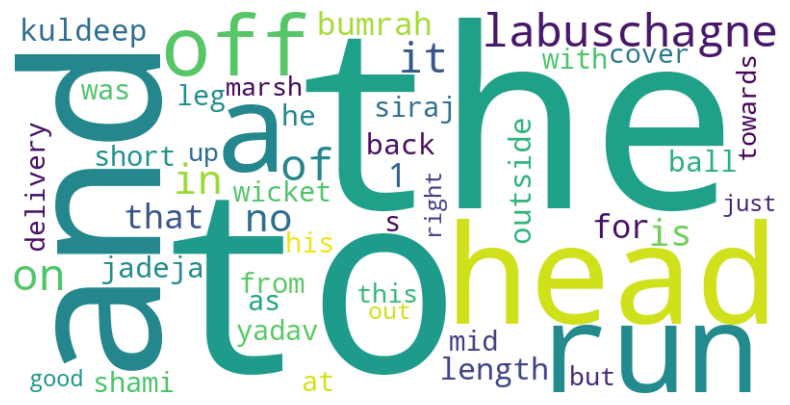

In [14]:
# Create a dictionary from the DataFrame
word_freq = dict(zip(most_used_words["Word"], most_used_words["Count"]))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

Visualize the sentiments using pie chart and bar graph

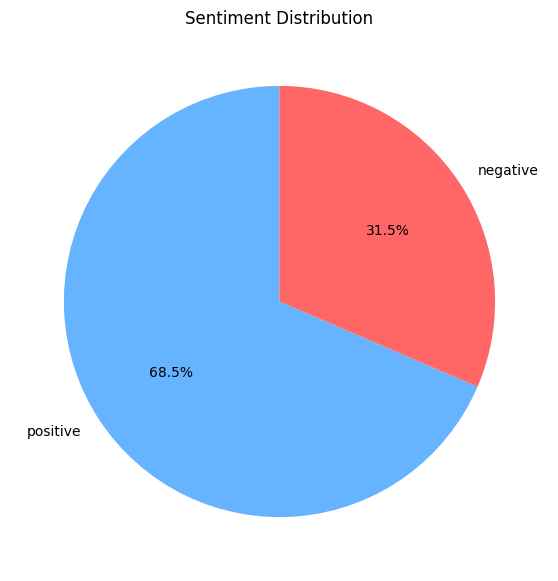

In [15]:
# Count the occurrences of 'positive' and 'negative'
sentiment_counts = df_cleaned['sentiment'].value_counts()

# **Pie Chart**
plt.figure(figsize=(7, 7))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666'])
plt.title('Sentiment Distribution')
plt.ylabel('')  # To remove the y-axis label
plt.show()

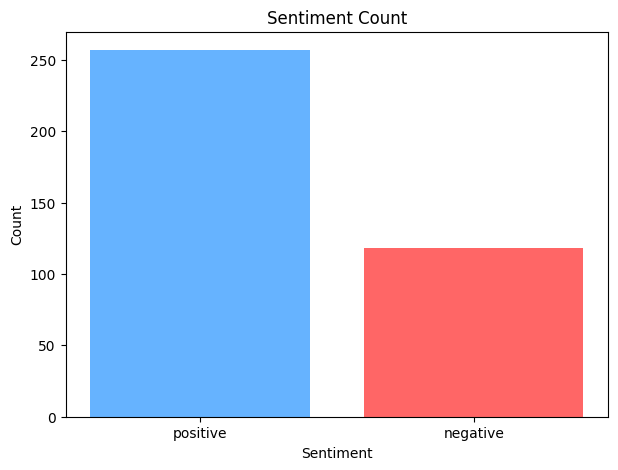

In [16]:
# **Bar Chart**
plt.figure(figsize=(7, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['#66b3ff', '#ff6666'])
plt.title('Sentiment Count')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()